# Multiple linear regression model and Data Loading functions

In [10]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd ..
!pip install TA-Lib


import talib

# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


--2024-09-26 18:14:09--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-09-26 18:14:10--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-09-26 18:14:10--  http://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Res

# Part 2: Data Inspection

               Open     High      Low    Close  Volume  Close_diff
Time                                                              
2008-08-01  1.55575  1.55886  1.55142  1.55609  755330         NaN
2008-08-03  1.55638  1.55790  1.55586  1.55658   76728     0.00049
2008-08-04  1.55662  1.56306  1.55526  1.55638  858293    -0.00020
2008-08-05  1.55624  1.55646  1.54442  1.54640  858740    -0.00998
2008-08-06  1.54650  1.55167  1.53956  1.54195  850798    -0.00445


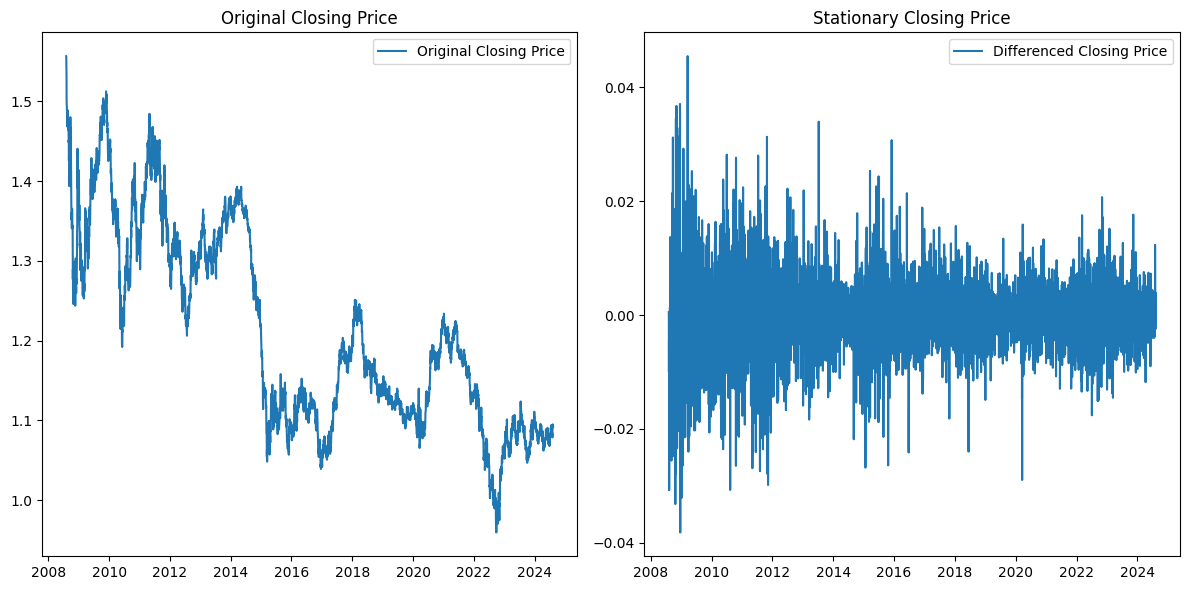

In [11]:
# Data loading
def data_loader(filepath):
    data = pd.read_csv(filepath)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')
    data.set_index('Time', inplace=True)

    return data

#select one feature
def featureEngineering(data, n_past=1):
    X = []
    Y= []
    for i in range(n_past, len(data)):
        X.append(data.iloc[i-n_past:i, -3].values)  # Select n_past number of rows for the closing price
        Y.append(data.iloc[i, -3])  # The target value

    feature_columns = [f'n_{i}' for i in range(1, n_past+1)]
    X_df = pd.DataFrame(X, columns=feature_columns)
    Y_df = pd.DataFrame(Y, columns=['response'])

    data = pd.concat([X_df, Y_df], axis=1)

    return data, X_df,Y_df

filepath = '/content/EURUSD_D1.csv'
datasetX = data_loader(filepath)

# Make the target (Closing price) stationary
datasetX['Close_diff'] = datasetX['Close'].diff()  # First difference of Closing price
print(datasetX.head())
datasetX.dropna(inplace=True)

# Create a figure and two subplots side by side
plt.figure(figsize=(12, 6))

# First subplot - Original Closing Price
plt.subplot(1, 2, 1)
plt.plot(datasetX['Close'], label='Original Closing Price')
plt.title('Original Closing Price')
plt.legend()

# Second subplot - Differenced Closing Price
plt.subplot(1, 2, 2)
plt.plot(datasetX['Close_diff'], label='Differenced Closing Price')
plt.title('Stationary Closing Price')
plt.legend()

# Show the combined plot
plt.tight_layout()
plt.show()



# Multivariate forecasting Approach

# Generate multivariate laggged features - manual hyper-parameter optimisation

In [12]:


# Feature Engineering

def multivariateFeatureEngineering(filepath):
    data = pd.read_csv(filepath)

    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    #Trend following Indicators:

    #SMA - identofy long term trend
    data['50_sma'] = data['Close'].rolling(window=50).mean()
    data['200_sma'] = data['Close'].rolling(window=200).mean()

    #EMA - trend analysis: more weight applied to recent points
    data['50_ema'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['100_ema'] = data['Close'].ewm(span=100, adjust=False).mean()

    #MACD
    data['12_ema'] = data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    #ADX
    # Calculate ADX using TA-Lib (14-period by default)
    data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Momentum indicators:

    #RSI - 14-period
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)

    #Stochastic Oscillator
    data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Close'],
                                                fastk_period=14, slowk_period=3, slowd_period=3)

    #Williams %R - Default period is 14
    data['Williams_R'] = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)

    #Volatility indicators#:

    #Bollinger Bands - Default period is 20 for moving average and standard deviation (can be adjusted)
    data['upper_band'], data['middle_band'], data['lower_band'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    #ATR -Default period for ATR is 14
    data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)


    data = data.dropna() # drop rows that have NA

    return data

filepath = '/content/EURUSD_D1.csv'
multivariateDataset = multivariateFeatureEngineering(filepath) #Include addtional features outside of OHLCV
#Drop time column , reset index
multivariateDataset = multivariateDataset.drop(columns=['Time']).reset_index(drop=True)

# reshape an input data into n_samples x timesteps x n_features.
# NOTE: data should be standardized

def multivariateFeatureLag(data, n_past, n_future, target_column=1):
    features = []
    response = []

    for i in range(n_past, len(data) - n_future + 1):
        # Extract the past n_past time steps as features
        features.append(data[i - n_past:i, :])  # Take all columns as features

        response.append(data[i + n_future - 1, target_column])  # Extract the target column for response

    # Move the conversion to NumPy arrays outside the loop
    features = np.array(features)  # Convert to NumPy array after the loop finishes
    response = np.array(response)  # Convert to NumPy array after the loop finishes

    features_flat = features.reshape(features.shape[0], -1) # make shape 2d

    return features_flat, response



######################################################## Hyper-paramter tuning NEXT #####################################################


# HYPER Parameter tuning and model selecction - Grid search

In [ ]:
import itertools
import logging
import talib
import csv

# Define the file and the header
csv_file = 'hyperparameter_results.csv'
header = ['Learning Rate', 'Lookback Window', 'Features', 'Test MSE', 'Test MAE','Test MBE', 'Test R2']


features = ['Open', 'High', 'Low', 'Volume', '50_sma', '200_sma', '50_ema',
                '100_ema', '12_ema', '26_ema', 'MACD_line', 'Signal_line',
                'MACD_histogram', 'ADX', 'RSI', 'stoch_k', 'stoch_d', 'Williams_R',
                'ATR']

learning_rates = [0.1 ,0.01, 0.001]
lookback_windows = [5, 10, 15, 20]
n_future = 1
target_col = -1

initial_feature = ['Close'] # Starting with the closing price

# Get all combinations of the features list and add to the initial feature (Closing Price)
feature_combinations = []
for i in range(len(features) + 1):
    for combination in itertools.combinations(features, i):
        feature_combinations.append(list(combination)+ initial_feature )

print(f"Total number of combinations: {len(feature_combinations)}")


filepath = '/content/EURUSD_D1.csv'
multivariateDataX = multivariateFeatureEngineering(filepath) #Include addtional features outside of OHLCV
cols = [col for col in multivariateDataX.columns if col!='Close'] +['Close'] #shift Close to end
multivariateDataX =multivariateDataX[cols]
#order columns


# Grid search loop
best_model = None
best_mae = 100
with open(csv_file, mode='w', newline='') as file:
  writer = csv.writer(file)

  writer.writerow(header) # header

for lr in learning_rates:
    for n_past_window_size in lookback_windows:
        for features in feature_combinations:
            # update dataset to contain only features selected
            multivariateDataNew = multivariateDataX[list(features)]

            m_data = multivariateDataNew.to_numpy()

            # Create lagged features based on the window size
            m_X, m_Y = multivariateFeatureLag(m_data,n_past_window_size, n_future, target_col )

            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(m_X, m_Y, test_size=0.2, random_state=42, shuffle=False)

            # Scale features
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Fit model
            model = LinearRegression(lr, n_iterations=1000)
            model.fit(X_train, y_train)

            # Make predictions
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            # Check for NaN in predictions and handle them (e.g., replace with 0)
            y_pred_test = np.nan_to_num(y_pred_test)

            # Calculate metrics
            test_mse = mean_squared_error(y_test, y_pred_test)
            test_mae = mean_absolute_error(y_test, y_pred_test)
            test_mbe = np.mean(y_pred_test - y_test) # mean bias error
            test_r2 = r2_score(y_test, y_pred_test)
            # MAPE,

            # store improving models
            if test_mae < best_mae:
                best_mae = test_mae
                 # Log results to CSV
                with open(csv_file, mode='a', newline='') as file:
                  writer = csv.writer(file)
                  writer.writerow([lr, n_past_window_size, features, test_mse, test_mae,test_mbe, test_r2])  # Write the result row


# Save the best model (you can save the model using joblib or pickle)
print(f"Best model found with Test MSE: {best_mae}")




Total number of combinations: 524288


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:510: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1220: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true -

# File DOWNLOAD

In [1]:
from google.colab import files
files.download('hyperparameter_results.csv')

FileNotFoundError: Cannot find file: hyperparameter_results.csv